# 빌트인 메서드를 사용한 트레이닝 및 평가

**저자:** [fchollet](https://twitter.com/fchollet)  
**생성일:** 2019/03/01  
**최종편집일:** 2023/06/25  
**설명:** `fit()` 및 `evaluate()`를 활용한 트레이닝 및 평가에 대한 전체 가이드입니다.

In [1]:
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install keras --upgrade --quiet

In [2]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

In [3]:
from keras import backend
print(backend.backend())

jax


In [4]:
import keras
keras.__version__

'3.4.1'

## 셋업

In [5]:
# torch Dataloader와 tf.data.Datasets를 사용하기 위해 torch와 TF를 import 합니다.
import torch
import tensorflow as tf

import os
import numpy as np
import keras
from keras import layers
from keras import ops

## 소개

이 가이드는 트레이닝 및 검증을 위한 빌트인 API(예: `Model.fit()`, `Model.evaluate()` 및 `Model.predict()`)를 사용할 때, 트레이닝, 평가 및 예측(추론) 모델을 다룹니다.

`fit()`를 활용하면서 자체 트레이닝 스텝 함수를 지정하는 데 관심이 있다면,
`fit()`에서 발생하는 것을 커스터마이즈하는 방법에 대한 가이드를 참조하세요.

* [TensorFlow로 커스텀 트레이닝 스텝 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/custom_train_step_in_tensorflow/)
* [JAX로 커스텀 트레이닝 스텝 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/custom_train_step_in_jax/)
* [PyTorch로 커스텀 트레이닝 스텝 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/custom_train_step_in_torch/)

자체 트레이닝 및 평가 루프를 처음부터 작성하는 데 관심이 있다면, 트레이닝 루프 작성에 대한 가이드를 참조하세요.

* [TensorFlow로 트레이닝 루프 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/writing_a_custom_training_loop_in_tensorflow/)
* [JAX로 트레이닝 루프 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/writing_a_custom_training_loop_in_jax/)
* [PyTorch로 트레이닝 루프 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/writing_a_custom_training_loop_in_torch/)

일반적으로, 빌트인 루프를 사용하든 직접 작성하든, 모델 트레이닝 및 평가는,
모든 종류의 Keras 모델(Sequential 모델, 함수형 API로 빌드한 모델, 모델 서브클래싱을 통해 처음부터 작성한 모델)에서,
엄격하게 동일한 방식으로 작동합니다.

## API 개요: 첫 번째 엔드투엔드 예시

모델의 빌트인 트레이닝 루프에 데이터를 전달할 때, 다음을 사용해야 합니다.

* NumPy 배열(데이터가 작고 메모리에 맞는 경우)
* [`keras.utils.PyDataset`](https://codecompose7.github.io/keras-doc-kr.github.io/api/utils/python_utils#pydataset-class)의 하위 클래스
* [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 객체
* PyTorch `DataLoader` 인스턴스

다음 몇 단락에서는,
MNIST 데이터 세트를 NumPy 배열로 사용하여 옵티마이저, 손실 및 메트릭을 사용하는 방법을 설명합니다.
그런 다음, 다른 옵션을 자세히 살펴보겠습니다.

다음 모델을 고려해 보겠습니다.
(여기서는 Functional API로 빌드하지만 Sequential 모델이거나 하위 클래스화된 모델일 수도 있습니다)


In [6]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

다음은 일반적인 엔드투엔드 워크플로우의 모습이며, 다음으로 구성됩니다.

* 트레이닝
* 원본 트레이닝 데이터에서 생성된 홀드아웃 세트에 대한 검증
* 테스트 데이터에 대한 평가

이 예제에서는 MNIST 데이터를 사용합니다.

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 데이터 전처리(NumPy 배열)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# 검증을 위해 10,000개의 샘플을 예약합니다.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


트레이닝 구성(옵티마이저, 손실, 메트릭)을 지정합니다.

In [8]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # 옵티마이저
    # 최소화할 손실 함수
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # 모니터링할 메트릭 목록
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`fit()`를 호출하는데,
이 함수는 데이터를 `batch_size` 크기의 "배치"로 나누어 모델을 트레이닝하고,
주어진 횟수의 `epoch` 동안 전체 데이터 세트에 걸쳐 반복적으로 반복(repeatedly iterating)합니다.


In [9]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # 각 에포크의 끝에서 검증 손실 및 메트릭을 모니터링하기 위한 일부 검증을 통과합니다.
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5756 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.1963 - val_sparse_categorical_accuracy: 0.9420
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.1712 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1281 - val_sparse_categorical_accuracy: 0.9632


반환된 `history` 객체는 트레이닝 중의 손실 값과 메트릭 값의 기록을 보관합니다.

In [10]:
print(history.history)

{'loss': [0.3381112813949585, 0.15711775422096252], 'sparse_categorical_accuracy': [0.9036999940872192, 0.9536199569702148], 'val_loss': [0.19625410437583923, 0.12810859084129333], 'val_sparse_categorical_accuracy': [0.9420000314712524, 0.963200032711029]}


`evaluate()`를 통해, 테스트 데이터에 대해 모델을 평가합니다.

In [11]:
# `evaluate`를 사용하여 테스트 데이터에 대해 모델을 평가합니다.
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# `predict`를 사용하여, 새 데이터에 대한 예측(확률 -- 마지막 레이어의 출력)을 생성합니다.
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9570  
test loss, test acc: [0.12502169609069824, 0.9624000191688538]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
predictions shape: (3, 10)


이제, 이 워크플로의 각 부분을 자세히 살펴보겠습니다.

## `compile()` 메서드: 손실, 메트릭 및 옵티마이저 지정

`fit()`로 모델을 트레이닝하려면, 손실 함수, 옵티마이저, 그리고 선택적으로 모니터링할 몇 가지 메트릭을 지정해야 합니다.

다음을 `compile()` 메서드의 인수로 모델에 전달합니다.

In [12]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 인수는 목록이어야 합니다. 모델은 원하는 수의 메트릭을 가질 수 있습니다.

모델에 여러 출력이 있는 경우, 각 출력에 대해 다른 손실과 메트릭을 지정할 수 있으며,
각 출력이 모델의 총 손실에 기여하는 정도를 조절할 수 있습니다.
이에 대한 자세한 내용은 **다중 입력, 다중 출력 모델에 데이터 전달** 섹션에서 확인할 수 있습니다.

기본 설정에 만족하는 경우, 많은 경우 옵티마이저, 손실 및 메트릭을 단축어로 문자열 식별자를 통해 지정할 수 있습니다.

In [13]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

나중에 재사용할 수 있도록, 모델 정의와 컴파일 단계를 함수에 넣겠습니다.
이 가이드의 여러 예제에서 이러한 함수를 여러 번 호출하겠습니다.

In [14]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

### 다양한 빌트인 옵티마이저, 손실 및 메트릭을 사용할 수 있습니다.

일반적으로, 처음부터 직접 손실, 메트릭 또는 옵티마이저를 만들 필요가 없습니다.
필요한 것이 이미 Keras API에 포함되어 있을 가능성이 높기 때문입니다.

옵티마이저:

* `SGD()`(모멘텀 포함 또는 미포함)
* `RMSprop()`
* `Adam()`
* 등

손실:

* `MeanSquaredError()`
* `KLDivergence()`
* `CosineSimilarity()`
* 등

메트릭:

* `AUC()`
* `Precision()`
* `Recall()`
* 등

### 커스텀 손실

커스텀 손실을 만들어야 하는 경우, Keras는 세 가지 방법을 제공합니다.

첫 번째 방법은 입력 `y_true` 및 `y_pred`를 받는 함수를 만드는 것입니다.
다음 예는 실제 데이터와 예측 간의 평균 제곱 오차를 계산하는 손실 함수를 보여줍니다.

In [15]:
def custom_mean_squared_error(y_true, y_pred):
    return ops.mean(ops.square(y_true - y_pred), axis=-1)


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# MSE를 사용하려면 레이블을 원핫 인코딩해야 합니다.
y_train_one_hot = ops.one_hot(y_train, num_classes=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0273


`y_true`와 `y_pred` 외의 매개변수를 사용하는 손실 함수가 필요한 경우,
`keras.losses.Loss` 클래스를 하위 클래스화하고, 다음 두 가지 메서드를 구현합니다.

* `__init__(self)`: 손실 함수 호출 중에 전달할 매개변수를 받습니다.
* `call(self, y_true, y_pred)`: 대상(y\_true)과 모델 예측(y\_pred)을 사용하여, 모델의 손실을 계산합니다.

평균 제곱 오차를 사용하려고 하지만, 예측 값이 0.5에서 멀어지는 것을 억제하는 추가 항을 사용하려고 한다고 가정해 보겠습니다.
(카테고리 대상이 원핫 인코딩되고, 0과 1 사이의 값을 사용한다고 가정)
이렇게 하면, 모델이 너무 확신하지 않도록 하는 인센티브가 생겨,
과적합을 줄이는 데 도움이 될 수 있습니다.
(시도해보기 전까지는 작동하는지 알 수 없습니다!)

방법은 다음과 같습니다.

In [16]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = ops.mean(ops.square(y_true - y_pred), axis=-1)
        reg = ops.mean(ops.square(0.5 - y_pred), axis=-1)
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = ops.one_hot(y_train, num_classes=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0494


### 커스텀 메트릭

API에 속하지 않는 메트릭이 필요한 경우,
[`keras.metrics.Metric`](https://codecompose7.github.io/keras-doc-kr.github.io/api/metrics/base_metric#metric-class) 클래스를 서브클래싱하여,
커스텀 메트릭을 쉽게 만들 수 있습니다.
4가지 메서드를 구현해야 합니다.

* `__init__(self)`: 메트릭의 상태 변수를 만듭니다.
* `update_state(self, y_true, y_pred, sample_weight=None)`: 대상 y\_true와 모델 예측 y\_pred를 사용하여, 상태 변수를 업데이트합니다.
* `result(self)`: 상태 변수를 사용하여, 최종 결과를 계산합니다.
* `reset_state(self)`: 메트릭의 상태를 다시 초기화합니다.

상태 업데이트와 결과 계산은 별도로 유지됩니다.(각각 `update_state()`와 `result()`에서)
어떤 경우에는 결과 계산이 매우 비용이 많이 들고, 주기적으로만 수행될 수 있기 때문입니다.

다음은 주어진 클래스에 속하는 것으로 올바르게 분류된 샘플 수를 세는,
`CategoricalTruePositives` 메트릭을 구현하는 방법을 보여주는 간단한 예입니다.

In [17]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(), name="ctp", initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = ops.reshape(ops.argmax(y_pred, axis=1), (-1, 1))
        values = ops.cast(y_true, "int32") == ops.cast(y_pred, "int32")
        values = ops.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = ops.cast(sample_weight, "float32")
            values = ops.multiply(values, sample_weight)
        self.true_positives.assign_add(ops.sum(values))

    def result(self):
        return self.true_positives.value

    def reset_state(self):
        # 각 에포크가 시작될 때마다, 메트릭 상태가 재설정됩니다.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_true_positives: 180394.5938 - loss: 0.5737
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - categorical_true_positives: 181251.6562 - loss: 0.1698
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - categorical_true_positives: 182727.2344 - loss: 0.1219


### 표준 서명에 맞지 않는 손실 및 메트릭 처리

손실과 메트릭의 압도적 다수는 `y_true`와 `y_pred`에서 계산할 수 있습니다.
여기서 `y_pred`는 모델의 출력이지만, 전부는 아닙니다.
예를 들어, 정규화 손실은 레이어 활성화만 필요할 수 있습니다. (이 경우 대상이 없음)
이 활성화는 모델 출력이 아닐 수 있습니다.

이러한 경우, 커스텀 레이어의 call 메서드 내부에서 `self.add_loss(loss_value)`를 호출할 수 있습니다.
이런 방식으로 추가된 손실은 트레이닝 중에 "메인" 손실(`compile()`에 전달된 손실)에 추가됩니다.
다음은 activity 정규화를 추가하는 간단한 예입니다.
(activity 정규화는 모든 Keras 레이어에 빌트인되어 있음에 유의하세요. 이 레이어는 구체적인 예를 제공하기 위한 것입니다)

In [18]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(ops.sum(inputs) * 0.1)
        return inputs  # Pass-through 레이어.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# activity 정규화를 레이어로 삽입
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# 정규화 구성 요소로 인해, 표시되는 손실은 이전보다 훨씬 높아질 것입니다.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6385


`add_loss()`를 통해 손실을 전달할 때,
모델에 이미 최소화해야 할 손실이 있으므로,
손실 함수 없이 `compile()`을 호출할 수 있습니다.

다음의 `LogisticEndpoint` 레이어를 고려해 보세요.
대상과 로짓을 입력으로 받고, `add_loss()`를 통해 교차 엔트로피 손실을 추적합니다.

In [19]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, targets, logits, sample_weights=None):
        # 트레이닝 시간 손실 값을 계산하고, `self.add_loss()`를 사용하여 레이어에 추가합니다.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # 추론 시간 예측 텐서를 반환합니다. (`.predict()`를 위해)
        return ops.softmax(logits)

다음과 같이, `loss` 인수 없이 컴파일된, 두 개의 입력(입력 데이터 및 대상)이 있는 모델에서 사용할 수 있습니다.

In [20]:
inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(targets, logits)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # 손실 인수가 없습니다!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.7274


다중 입력 모델을 트레이닝하는 방법에 대한 자세한 내용은,
**다중 입력, 다중 출력 모델에 데이터 전달** 섹션을 참조하세요.

### 검증 홀드아웃 세트를 자동으로 따로 설정

첫 번째 엔드투엔드 예제에서, `validation_data` 인수를 사용하여,
각 에포크의 끝에서 검증 손실과 검증 메트릭을 평가하기 위해,
NumPy 배열 `(x_val, y_val)`의 튜플을 모델에 전달했습니다.

또 다른 옵션은 다음과 같습니다.
`validation_split` 인수를 사용하면 검증을 위해, 자동으로 트레이닝 데이터의 일부를 예약할 수 있습니다.
인수 값은 검증을 위해 예약할 데이터의 비율을 나타내므로, 0보다 크고 1보다 작은 숫자로 설정해야 합니다.
예를 들어, `validation_split=0.2`는 "검증에 데이터의 20% 사용"을 의미하고,
`validation_split=0.6`은 "검증에 데이터의 60% 사용"을 의미합니다.

검증을 계산하는 방법은, 셔플링 전에 `fit()` 호출에서 수신한 배열의 마지막 x% 샘플을 가져오는 것입니다.

NumPy 데이터로 트레이닝할 때만, `validation_split`을 사용할 수 있습니다.

In [21]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.8384 - val_loss: 0.2186 - val_sparse_categorical_accuracy: 0.9352


## [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 데이터 세트를 사용한 트레이닝 및 평가

지난 몇 단락에서, 손실, 메트릭, 옵티마이저를 처리하는 방법을 살펴보았고,
데이터가 NumPy 배열로 전달될 때,
`fit()`에서 `validation_data` 및 `validation_split` 인수를 사용하는 방법을 살펴보았습니다.

또 다른 옵션은 [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), PyTorch `DataLoader` 또는 Keras `PyDataset`와 같은,
iterator와 유사한 것을 사용하는 것입니다. 전자를 살펴보겠습니다.

[`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API는 빠르고 확장 가능한 방식으로 데이터를 로드하고 사전 처리하기 위한 TensorFlow 2.0의 유틸리티 세트입니다.
`Datasets` 생성에 대한 전체 가이드는 [tf.data 문서](https://www.tensorflow.org/guide/data)를 참조하세요.

**JAX, PyTorch 또는 TensorFlow 등 사용하는 백엔드에 관계없이 [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data)를 사용하여 Keras 모델을 트레이닝할 수 있습니다.**
`Dataset` 인스턴스를 `fit()`, `evaluate()` 및 `predict()` 메서드에 직접 전달할 수 있습니다.


In [22]:
model = get_compiled_model()

# 먼저, 트레이닝 데이터셋 인스턴스를 만들어 보겠습니다.
# 예를 들어, 이전과 동일한 MNIST 데이터를 사용하겠습니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# 데이터 세트를 셔플하고, 분할합니다.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 이제 테스트 데이터 세트를 얻습니다.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# 데이터 세트가 이미 배치를 처리하므로, `batch_size` 인수를 전달하지 않습니다.
model.fit(train_dataset, epochs=3)

# 데이터 세트에 대해 평가하거나 예측할 수도 있습니다.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5606 - sparse_categorical_accuracy: 0.8454
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - loss: 0.1663 - sparse_categorical_accuracy: 0.9504
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.1145 - sparse_categorical_accuracy: 0.9669
Evaluate
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9626


{'loss': 0.10927928984165192, 'compile_metrics': 0.9665000438690186}

각 에포크가 끝나면 Dataset이 재설정되므로, 다음 에포크에서 재사용할 수 있습니다.

이 Dataset에서 특정 수의 배치에 대해서만 트레이닝을 실행하려면,
`steps_per_epoch` 인수를 전달할 수 있습니다.
이 인수는 다음 에포크로 넘어가기 전에 이 Dataset을 사용하여 모델이 실행해야 하는 트레이닝 단계 수를 지정합니다.

In [23]:
model = get_compiled_model()

# 트레이닝 데이터 세트 준비
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 에포크당 100개 배치만 사용하세요. (64 * 100개 샘플)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2256 - sparse_categorical_accuracy: 0.6520
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.3761 - sparse_categorical_accuracy: 0.8863
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.3402 - sparse_categorical_accuracy: 0.9011


`fit()`에서 `validation_data` 인수로 `Dataset` 인스턴스를 전달할 수도 있습니다.

In [24]:
model = get_compiled_model()

# 트레이닝 데이터 세트 준비
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 검증 데이터 세트 준비
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.8439 - val_loss: 0.1961 - val_sparse_categorical_accuracy: 0.9421


각 에포크가 끝나면, 모델은 검증 데이터 세트에 걸쳐 반복하고, 검증 손실과 검증 메트릭을 계산합니다.

이 데이터 세트에서 특정 수의 배치에 대해서만 검증을 실행하려면,
`validation_steps` 인수를 전달할 수 있습니다.
이 인수는 검증을 중단하고 다음 에포크로 넘어가기 전에,
모델이 검증 데이터 세트로 실행해야 하는 검증 단계 수를 지정합니다.

In [25]:
model = get_compiled_model()

# 트레이닝 데이터 세트 준비
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 검증 데이터 세트 준비
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # `validation_steps` 인수를 사용하여, 데이터 세트의 처음 10개 배치만 사용하여 검증을 실행합니다.
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5595 - sparse_categorical_accuracy: 0.8425 - val_loss: 0.3158 - val_sparse_categorical_accuracy: 0.9203


검증 데이터 세트는 각 사용 후 재설정되므로, 항상 에포크마다 동일한 샘플에 대해 평가하게 됩니다.

`Dataset` 객체에서 트레이닝할 때는 `validation_split` 인수(트레이닝 데이터에서 홀드아웃 세트를 생성)가 지원되지 않습니다.
이 기능은 데이터 세트의 샘플을 인덱싱할 수 있는 기능이 필요하지만,
일반적으로 `Dataset` API에서는 불가능합니다.

## `PyDataset` 인스턴스를 사용한 트레이닝 및 평가

[`keras.utils.PyDataset`](https://codecompose7.github.io/keras-doc-kr.github.io/api/utils/python_utils#pydataset-class)는 두 가지 중요한 속성이 있는 Python generator를 얻기 위해 서브클래싱할 수 있는 유틸리티입니다.

* 멀티프로세싱과 잘 작동합니다.
* 셔플링할 수 있습니다. (예: `fit()`에서 `shuffle=True`를 전달할 때)

`PyDataset`은 두 가지 메서드를 구현해야 합니다.

* `__getitem__`
* `__len__`

`__getitem__` 메서드는 전체 배치를 반환해야 합니다.
에포크 사이에 데이터 세트를 수정하려면, `on_epoch_end`를 구현할 수 있습니다.

간단한 예는 다음과 같습니다.

In [26]:
class ExamplePyDataset(keras.utils.PyDataset):
    def __init__(self, x, y, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]
        return batch_x, batch_y


train_py_dataset = ExamplePyDataset(x_train, y_train, batch_size=32)
val_py_dataset = ExamplePyDataset(x_val, y_val, batch_size=32)

모델을 fit하려면, 대신 데이터 세트를 `x` 인수로 전달합니다.
(데이터 세트에 타겟이 포함되어 있으므로, `y` 인수는 필요 없음)
그리고, 검증 데이터 세트를 `validation_data` 인수로 전달합니다.
그리고 데이터 세트가 이미 배치되었으므로, `batch_size` 인수는 필요 없습니다!

In [27]:
model = get_compiled_model()
model.fit(train_py_dataset, batch_size=64, validation_data=val_py_dataset, epochs=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5052 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.1565 - val_sparse_categorical_accuracy: 0.9562


모델을 평가하는 것도 마찬가지로 쉽습니다.

In [28]:
model.evaluate(val_py_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9518


[0.1564897745847702, 0.9562000632286072]

중요한 점은, `PyDataset` 객체가 병렬 처리 구성을 처리하는 세 가지 일반적인 생성자 인수를 지원한다는 것입니다.

* `workers`: 멀티스레딩 또는 멀티프로세싱에서 사용할 워커 수입니다. 일반적으로, CPU의 코어 수로 설정합니다.
* `use_multiprocessing`: 병렬 처리를 위해 Python 멀티프로세싱을 사용할지 여부입니다.
  이를 `True`로 설정하면, 데이터 세트가 여러 개의 포크된 프로세스에서 복제됩니다.
  이는 병렬 처리에서 I/O 레벨이 아닌 컴퓨팅 레벨의 이점을 얻는 데 필요합니다.
  그러나, 데이터 세트를 안전하게 피클링(pickled)할 수 있는 경우에만, `True`로 설정할 수 있습니다.
* `max_queue_size`: 멀티스레드 또는 multipricessed 설정에서 데이터 세트에 걸쳐 반복할 때,
  대기열에 보관할 최대 배치 수입니다.
  이 값을 줄여, 데이터 세트의 CPU 메모리 사용량을 줄일 수 있습니다. 기본값은 10입니다.

기본적으로, 멀티프로세싱은 비활성화되어 있으며(`use_multiprocessing=False`) 스레드가 하나만 사용됩니다.
문제가 발생하지 않도록, Python `if __name__ == "__main__":` 블록 내부에서 코드가 실행되는 경우에만,
`use_multiprocessing`을 켜야 합니다.

다음은 4스레드, 멀티프로세스되지 않은 예입니다.

In [29]:
train_py_dataset = ExamplePyDataset(x_train, y_train, batch_size=32, workers=4)
val_py_dataset = ExamplePyDataset(x_val, y_val, batch_size=32, workers=4)

model = get_compiled_model()
model.fit(train_py_dataset, batch_size=64, validation_data=val_py_dataset, epochs=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5173 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.1621 - val_sparse_categorical_accuracy: 0.9534


## PyTorch `DataLoader` 객체를 사용한 트레이닝 및 평가

모든 빌트인 트레이닝 및 평가 API는 `torch.utils.data.Dataset` 및 `torch.utils.data.DataLoader` 객체와도 호환됩니다.
PyTorch 백엔드나 JAX 또는 TensorFlow 백엔드를 사용하든 상관없습니다. 간단한 예를 살펴보겠습니다.

배치 중심(batch-centric)인 `PyDataset`과 달리, PyTorch `Dataset` 객체는 샘플 중심입니다.
`__len__` 메서드는 샘플 수를 반환하고, `__getitem__` 메서드는 특정 샘플을 반환합니다.

In [30]:
class ExampleTorchDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


train_torch_dataset = ExampleTorchDataset(x_train, y_train)
val_torch_dataset = ExampleTorchDataset(x_val, y_val)

PyTorch Dataset을 사용하려면, 배치 및 셔플링을 처리하는 `Dataloader`로 래핑해야 합니다.

In [31]:
train_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset, batch_size=32, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_torch_dataset, batch_size=32, shuffle=True
)

이제 다른 iterator와 마찬가지로, Keras API에서 이를 사용할 수 있습니다.

In [32]:
model = get_compiled_model()
model.fit(train_dataloader, batch_size=64, validation_data=val_dataloader, epochs=1)
model.evaluate(val_dataloader)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4999 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.1587 - val_sparse_categorical_accuracy: 0.9530
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.1677 - sparse_categorical_accuracy: 0.9505


[0.15868884325027466, 0.9530000686645508]

## 샘플 가중치와 클래스 가중치 사용

기본 설정에서 샘플의 가중치는 데이터 세트에서의 빈도에 따라 결정됩니다.
샘플 빈도와 무관하게 데이터에 가중치를 부여하는 방법은 두 가지가 있습니다.

* 클래스 가중치
* 샘플 가중치

### 클래스 가중치

이것은 `Model.fit()`에 `class_weight` 인수에 사전을 전달하여 설정합니다.
이 딕셔너리는 클래스 인덱스를 이 클래스에 속하는 샘플에 사용해야 하는 가중치에 매핑합니다.

이것은 리샘플링 없이 클래스를 균형 있게 조정하거나,
특정 클래스에 더 많은 중요성을 부여하는 모델을 트레이닝하는 데 사용할 수 있습니다.

예를 들어, 데이터에서 클래스 "0"이 클래스 "1"의 절반으로 표현된 경우,
`Model.fit(..., class_weight={0: 1., 1: 0.5})`를 사용할 수 있습니다.

다음은 클래스 가중치 또는 샘플 가중치를 사용하여,
클래스 #5(MNIST 데이터 세트의 숫자 "5")의 올바른 분류에 더 많은 중요성을 부여하는 NumPy 예제입니다.


In [33]:
class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # 클래스 "5"에 대해 가중치 "2"를 설정하여, 이 클래스를 2배 더 중요하게 만듭니다.
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.8310


### 샘플 가중치

세밀한 제어를 위해, 또는 분류기를 빌드하지 않는 경우, "샘플 가중치"를 사용할 수 있습니다.

* NumPy 데이터에서 트레이닝하는 경우: `Model.fit()`에 `sample_weight` 인수를 전달합니다.
* [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 또는 다른 종류의 iterator에서 트레이닝하는 경우: `(input_batch, label_batch, sample_weight_batch)` 튜플을 생성(Yield)합니다.

"샘플 가중치" 배열은, 배치의 각 샘플이 총 손실을 계산할 때, 가져야 하는 가중치를 지정하는 숫자 배열입니다.
불균형 분류 문제에서 일반적으로 사용됩니다. (드물게 보이는 클래스에 더 많은 가중치를 부여하는 것이 목표)

사용된 가중치가 1과 0인 경우,
배열을 손실 함수의 _마스크_ 로 사용할 수 있습니다.
(전체 손실에 대한 특정 샘플의 기여도를 완전히 무시)

In [34]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.8206


다음은 일치하는 `Dataset` 예입니다.

In [35]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# 샘플 가중치를 포함하는 데이터 세트를 만듭니다.
# (반환 튜플의 3번째 요소).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# 데이터 세트를 셔플하고, 슬라이스 합니다.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6104 - sparse_categorical_accuracy: 0.8462


## 다중 입력, 다중 출력 모델에 데이터 전달

이전 예에서, 우리는 단일 입력(`(764,)` 모양의 텐서)과 단일 출력(`(10,)` 모양의 예측 텐서)을 갖는 모델을 고려했습니다.
하지만 여러 입력 또는 출력이 있는 모델은 어떨까요?

다음 모델을 고려해 보겠습니다.
여기에는 `(32, 32, 3)` 모양의 이미지 입력(`(height, width, channels)`)과
`(None, 10)` 모양의 시계열 입력(`(timesteps, features)`)이 있습니다.
이 모델은 이러한 입력의 조합에서 계산된 두 가지 출력을 갖습니다.
즉, "점수"(`(1,)` 모양)와 5개 클래스에 대한 확률 분포(`(5,)` 모양)입니다.

In [36]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input],
    outputs=[score_output, class_output]
)

이 모델을 그려보면,
여기서 무엇을 하고 있는지 명확하게 볼 수 있을 것입니다.
(플롯에 표시된 모양은 샘플별 모양이 아니라 배치 모양입니다)

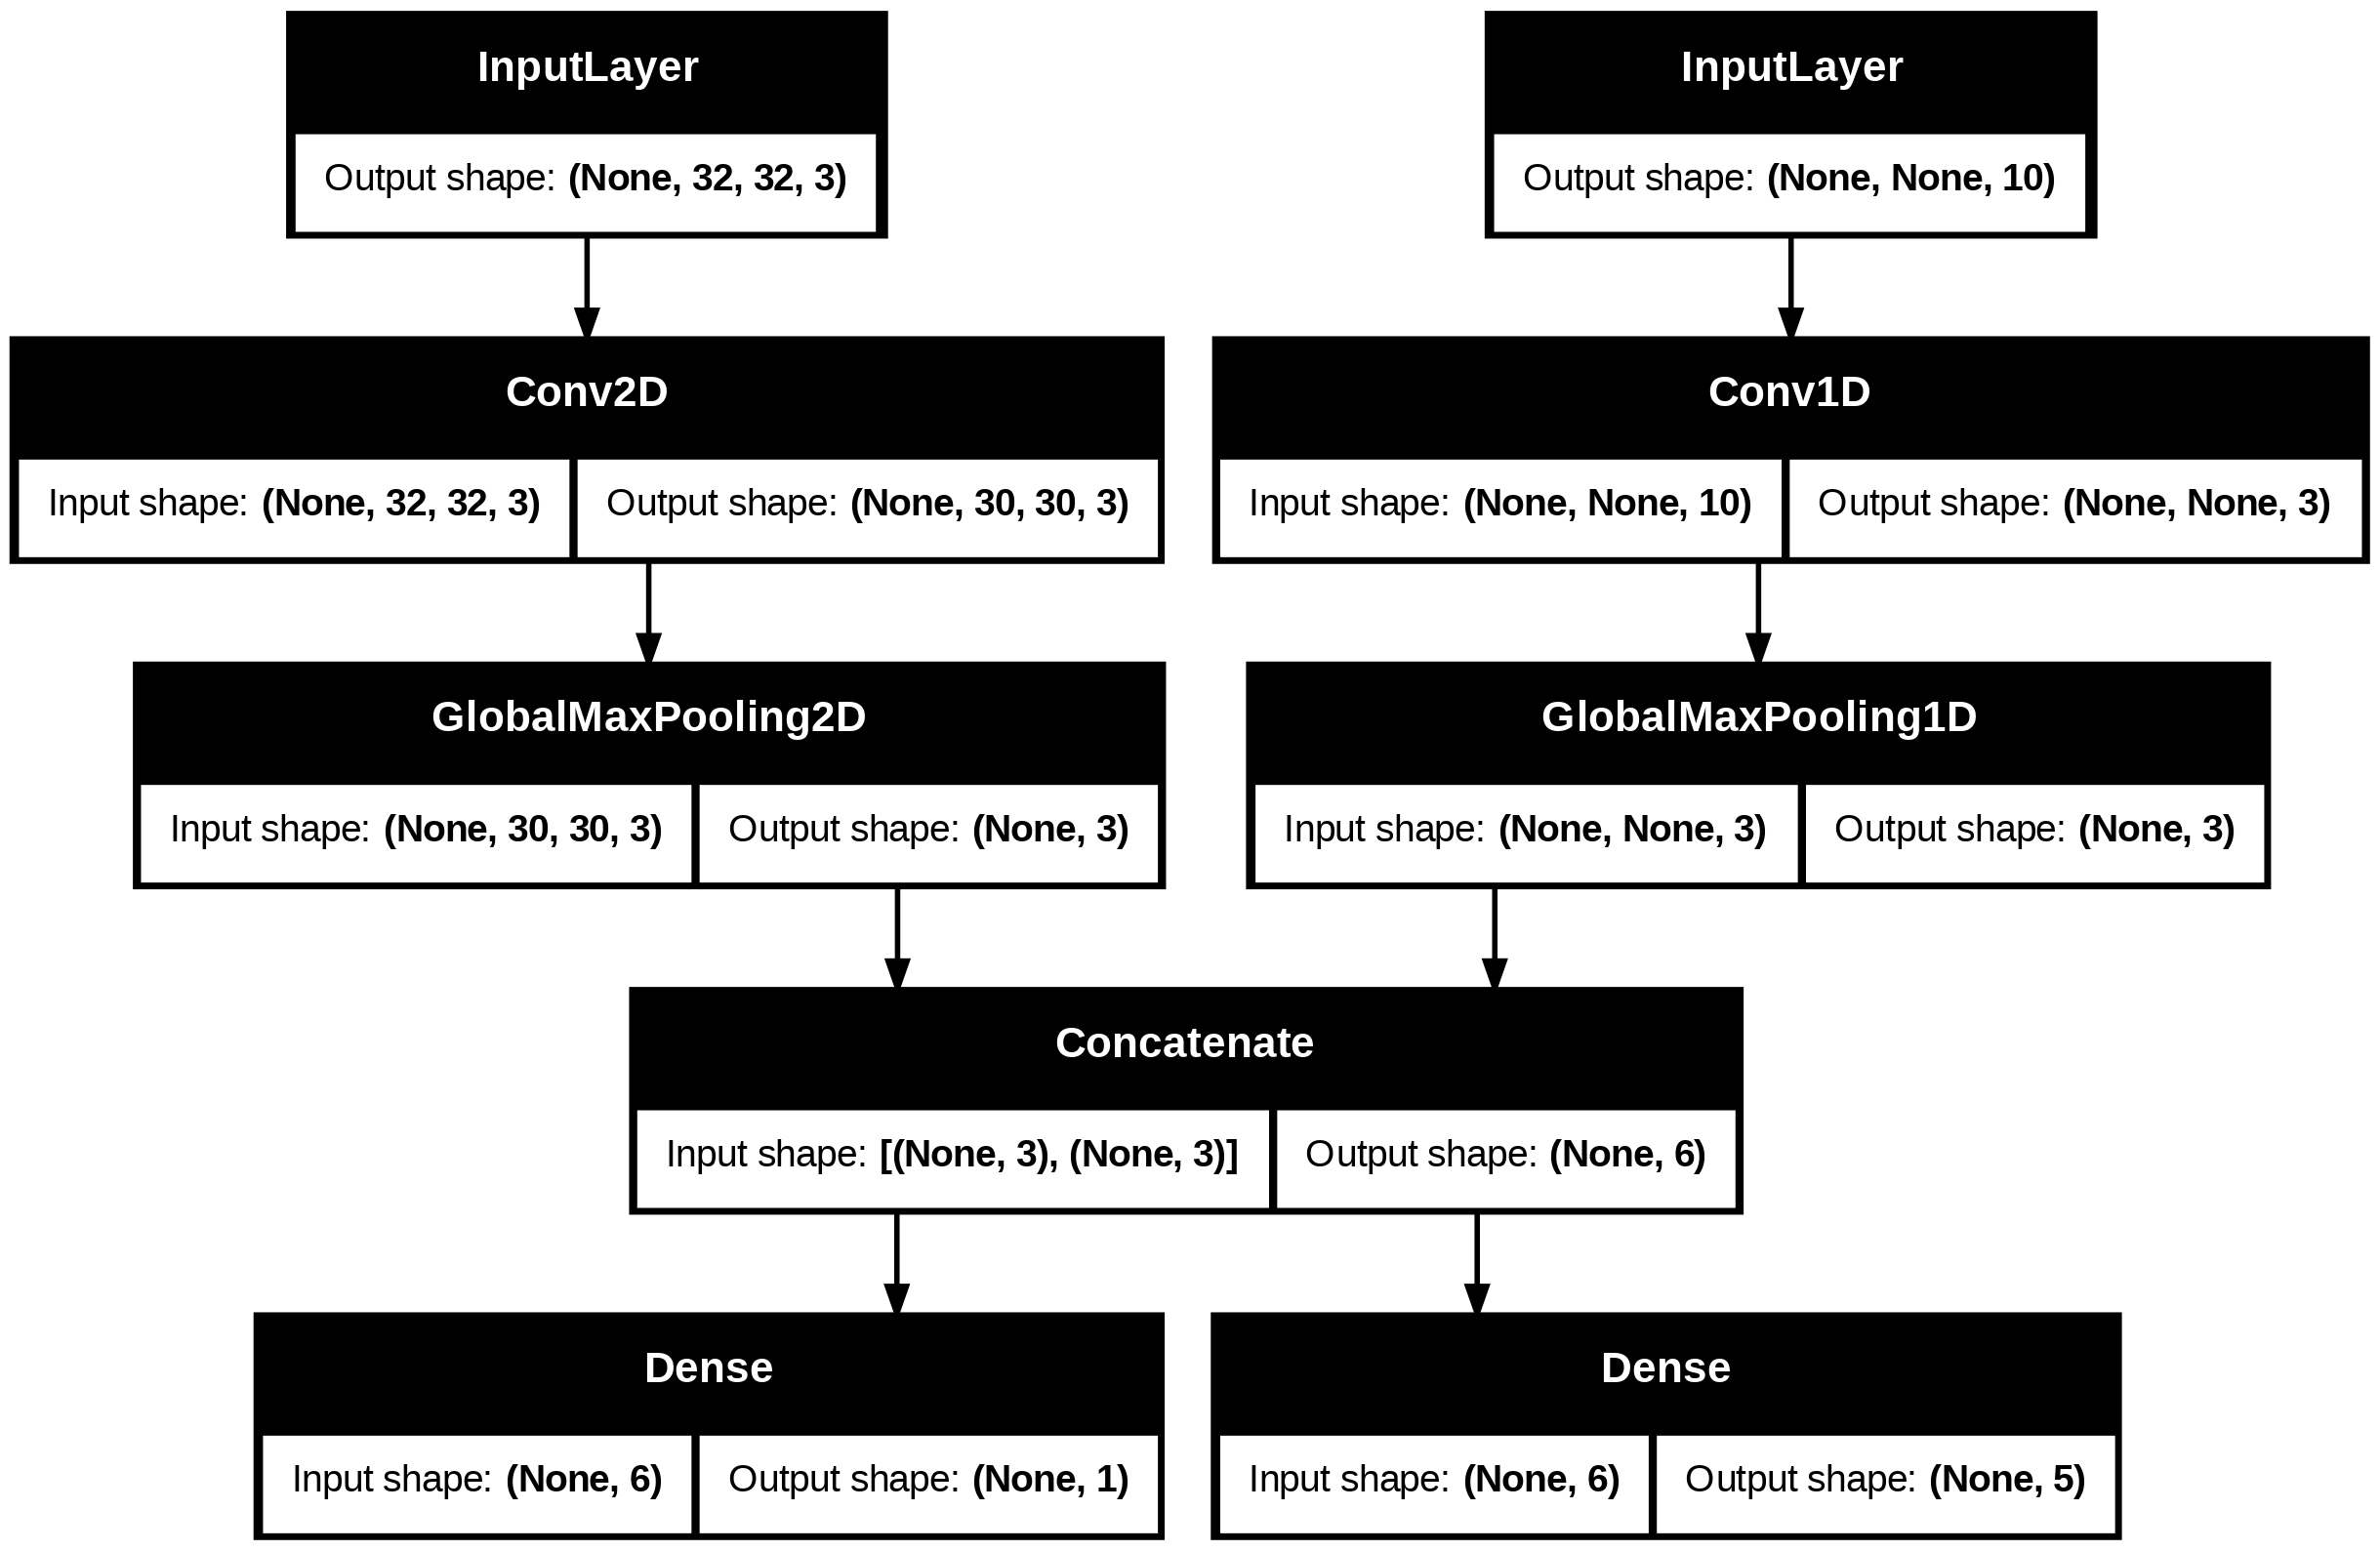

In [37]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

컴파일 시점에, 손실 함수를 목록으로 전달하여,
다양한 출력에 대해 다양한 손실을 지정할 수 있습니다.

In [38]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.MeanSquaredError(),
        keras.losses.CategoricalCrossentropy(),
    ],
)

모델에 단일 손실 함수만 전달하면, 모든 출력에 동일한 손실 함수가 적용됩니다. (여기서는 적합하지 않음)

메트릭의 경우도 마찬가지입니다.

In [39]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.MeanSquaredError(),
        keras.losses.CategoricalCrossentropy(),
    ],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

출력 레이어에 이름을 지정했으므로, dict를 통해 출력당 손실과 메트릭을 지정할 수도 있습니다.

In [40]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

출력이 2개 이상인 경우, 명시적 이름과 dict을 사용하는 것이 좋습니다.

`loss_weights` 인수를 사용하여, 다양한 출력별 손실에 다른 가중치를 부여할 수 있습니다.
(예: 클래스 손실의 중요도를 2배로 부여하여, 예시에서 "score" 손실에 특권을 부여할 수 있음)

In [41]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

예측을 위한 출력이지만 트레이닝을 위한 출력이 아닌 경우,
특정 출력에 대한 손실을 계산하지 않도록 선택할 수도 있습니다.

In [42]:
# 리스트 손실 버전
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# 또는 dict 손실 버전
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

`fit()`에서 다중 입력 또는 다중 출력 모델에 데이터를 전달하는 것은,
compile에서 손실 함수를 지정하는 것과 비슷한 방식으로 작동합니다.
**NumPy 배열의 목록**(손실 함수를 받은 출력과 1:1로 매핑)을 전달하거나,
**출력 이름을 NumPy 배열에 매핑하는 dict**를 전달할 수 있습니다.

In [43]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.MeanSquaredError(),
        keras.losses.CategoricalCrossentropy(),
    ],
)

# 더미 NumPy 데이터 생성
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# 리스트에 대해 fit
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# 또는, dict에 대해 fit
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},  # Keras 3.5.0에서 에러
    # [score_targets, class_targets],
    batch_size=32,
    epochs=1,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 18.3498
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 18.3966


`Dataset`의 사용 사례는 다음과 같습니다.
NumPy 배열에서 한 것과 비슷하게, `Dataset`은 dict 튜플을 반환해야 합니다.

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - loss: 19.8473


## 콜백 사용

Keras의 콜백은 트레이닝 중 여러 지점(에포크 시작 시, 배치 종료 시, 에포크 종료 시 등)에서 호출되는 객체입니다.
다음과 같은 특정 동작을 구현하는 데 사용할 수 있습니다.

* 트레이닝학습 중 여러 지점에서 검증 수행 (빌트인 에포크 당 검증 외)
* 정기적으로 또는 특정 정확도 임계값을 초과할 때 모델에 체크포인트 지정
* 트레이닝이 정체(plateauing)되는 듯할 때, 모델의 학습률 변경
* 트레이닝이 정체되는 듯할 때, 최상위 레이어 미세 조정
* 트레이닝이 종료되거나 특정 성능 임계값을 초과할 때, 이메일 또는 인스턴트 메시지 알림 전송
* 기타

콜백은 `fit()` 호출에 목록으로 전달할 수 있습니다.

In [45]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # `val_loss`가 더 이상 개선되지 않을 때 트레이닝 중단
        monitor="val_loss",
        # "개선되지 않음"은 "1e-2 이상 개선되지 않음"을 의미
        min_delta=1e-2,
        # "개선되지 않음"은 "최소 2 에포크 동안 유지"될 때로 정의
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6109 - sparse_categorical_accuracy: 0.8238 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9290
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9453 - val_loss: 0.1775 - val_sparse_categorical_accuracy: 0.9452
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.1258 - sparse_categorical_accuracy: 0.9618 - val_loss: 0.1596 - val_sparse_categorical_accuracy: 0.9503
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0982 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.1446 - val_sparse_categorical_accuracy: 0.9577
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0803 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.1334 - val_sparse_categorical_accuracy: 0.9621
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0615 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.1353 - val_sparse_categorical_accuracy: 0

### 다양한 빌트인 콜백을 사용할 수 있습니다

Keras에는 이미 다음과 같은 많은 빌트인 콜백이 있습니다.

* `ModelCheckpoint`: 주기적으로 모델을 저장합니다.
* `EarlyStopping`: 트레이닝이 더 이상 검증 메트릭을 개선하지 못할 때, 트레이닝을 중지합니다.
* `TensorBoard`: 주기적으로 [TensorBoard](https://www.tensorflow.org/tensorboard)에서 시각화할 수 있는 모델 로그를 작성합니다. (자세한 내용은 "시각화" 섹션 참조)
* `CSVLogger`: 손실 및 메트릭 데이터를 CSV 파일로 스트리밍합니다.
* 기타

전체 목록은 [콜백 문서](https://codecompose7.github.io/keras-doc-kr.github.io/api/callbacks/)를 참조하세요.

### 자신만의 콜백 작성하기

베이스 클래스 [`keras.callbacks.Callback`](https://codecompose7.github.io/keras-doc-kr.github.io/api/callbacks/base_callback#callback-class)를 확장하여, 커스텀 콜백을 만들 수 있습니다.
콜백은 클래스 속성 `self.model`을 통해, 연관된 모델에 액세스할 수 있습니다.

[커스텀 콜백 작성에 대한 전체 가이드](https://codecompose7.github.io/keras-doc-kr.github.io/guides/writing_your_own_callbacks/)를 읽어보세요.

다음은 트레이닝 중, 배치별 손실 값 목록을 저장하는 간단한 예입니다.

In [46]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

## 모델 체크포인팅

비교적 큰 데이터 세트에 대해 모델을 트레이닝할 때는,
모델의 체크포인트를 빈번한 간격으로 저장하는 것이 중요합니다.

이를 달성하는 가장 쉬운 방법은 `ModelCheckpoint` 콜백을 사용하는 것입니다.

In [47]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # 모델을 저장할 경로
        # 아래 두 매개변수는 `val_loss` 점수가 개선된 경우에만,
        # 현재 체크포인트를 덮어쓴다는 것을 의미합니다.
        # 저장된 모델 이름에는 현재 에포크가 포함됩니다.
        filepath="mymodel_{epoch}.keras",
        save_best_only=True,  # `val_loss`가 개선된 경우에만 모델을 저장합니다.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=2,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/2
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.6248 - sparse_categorical_accuracy: 0.8266
Epoch 1: val_loss improved from inf to 0.23779, saving model to mymodel_1.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.8270 - val_loss: 0.2378 - val_sparse_categorical_accuracy: 0.9267
Epoch 2/2
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9461
Epoch 2: val_loss improved from 0.23779 to 0.17779, saving model to mymodel_2.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.1778 - val_sparse_categorical_accuracy: 0.9461


`ModelCheckpoint` 콜백은 결함 허용성(fault-tolerance)을 구현하는 데 사용할 수 있습니다.
즉, 트레이닝이 무작위로 중단되는 경우,
모델의 마지막 저장된 상태에서 트레이닝을 다시 시작하는 기능입니다.
다음은 기본적인 예입니다.

In [48]:
# 모든 체크포인트를 저장할 디렉토리를 준비합니다.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # 최신 모델을 복원하거나,
    # 체크포인트를 사용할 수 없는 경우 새 모델을 만듭니다.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # 이 콜백은 매 100 배치마다 모델을 저장합니다.
    # 저장된 모델 이름에 트레이닝 손실을 포함합니다.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/model-loss={loss:.2f}.keras", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - loss: 0.5188 - sparse_categorical_accuracy: 0.8488


모델을 저장하고 복원하기 위한 콜백을 직접 작성합니다.

직렬화 및 저장에 대한 전체 가이드는 [모델 저장 및 직렬화 가이드](https://codecompose7.github.io/keras-doc-kr.github.io/guides/serialization_and_saving/)를 참조하세요.

## 학습률 스케쥴 사용

딥러닝 모델을 트레이닝할 때, 일반적인 패턴은 트레이닝이 진행됨에 따라 학습을 점진적으로 줄이는 것입니다.
이를 일반적으로 "학습률 감쇠(learning rate decay)"라고 합니다.

학습 감쇠 스케쥴은 정적(현재 에포크 또는 현재 배치 인덱스의 함수로 미리 고정)이거나,
동적(특히 검증 손실과 같은 모델의 현재 동작에 대응)일 수 있습니다.

### 스케줄을 옵티마이저에 전달

옵티마이저에서 `learning_rate` 인수로 스케쥴 객체를 전달하여,
정적 학습률 감쇠 스케쥴을 쉽게 사용할 수 있습니다.

In [49]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

여러 가지 빌트인 스케줄을 사용할 수 있습니다:
`ExponentialDecay`, `PiecewiseConstantDecay`, `PolynomialDecay`, `InverseTimeDecay`.

### 콜백을 사용하여 동적 학습률 스케쥴 구현

이러한 스케줄 객체로는 동적 학습률 스케줄(예: 검증 손실이 더 이상 개선되지 않을 때, 학습률 감소)을 달성할 수 없습니다.
옵티마이저가 검증 메트릭에 액세스할 수 없기 때문입니다.

그러나, 콜백은 검증 메트릭을 포함한 모든 메트릭에 액세스할 수 있습니다!
따라서, 옵티마이저에서 현재 학습률을 수정하는 콜백을 사용하여, 이 패턴을 달성할 수 있습니다.
사실, 이것은 `ReduceLROnPlateau` 콜백으로 빌트인되어 있습니다.

## TensorBoard를 사용하여 트레이닝하는 동안 손실 및 메트릭 시각화

트레이닝하는 동안 모델을 주시하는 가장 좋은 방법은 [TensorBoard](https://www.tensorflow.org/tensorboard)를 사용하는 것입니다.
로컬에서 실행할 수 있는 브라우저 기반 애플리케이션으로 다음을 제공합니다.

* 트레이닝 및 평가에 대한 손실 및 메트릭의 라이브 플롯
* (선택 사항) 레이어 활성화의 히스토그램 시각화
* (선택 사항) `Embedding` 레이어에서 학습한 임베딩 공간의 3D 시각화

pip로 TensorFlow를 설치한 경우, 명령줄에서 TensorBoard를 시작할 수 있어야 합니다.

```shell
tensorboard --logdir=/full_path_to_your_logs
```

### TensorBoard 콜백 사용

Keras 모델과 `fit()` 메서드로 TensorBoard를 사용하는 가장 쉬운 방법은 `TensorBoard` 콜백입니다.

가장 간단한 케이스로, 콜백이 로그를 쓸 위치를 지정하기만 하면 됩니다.

In [50]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # 히스토그램 시각화를 기록하는 빈도
    embeddings_freq=0,  # 임베딩 시각화를 기록하는 빈도
    update_freq="epoch",
)  # 로그를 작성하는 빈도(기본값: 에포크당 한 번)

자세한 내용은 [`TensorBoard` 콜백에 대한 문서](https://codecompose7.github.io/keras-doc-kr.github.io/api/callbacks/tensorboard/)를 참조하세요.